<a href="https://colab.research.google.com/github/Soccolo/GPVAE/blob/main/PriorVAE_2d_GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing libraries

In [ ]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install arviz==0.13.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 73.2 MB/s eta 0:00:00
  Attempting uninstall: arviz
    Found existing installation: arviz 0.15.1
    Uninstalling arviz-0.15.1:
      Successfully uninstalled arviz-0.15.1


In [ ]:
!pip install pyreadr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.0/363.0 kB 15.5 MB/s eta 0:00:00


In [ ]:
!pip install numpyro

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.6/304.6 kB 13.3 MB/s eta 0:00:00


In [ ]:
# general libraries
import time
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import arviz as az
import pyreadr

# JAX
import jax.numpy as jnp
from jax import random, lax, jit, ops
from jax.example_libraries import stax

from functools import partial

# Numpyro
import numpyro
import numpyro.distributions as dist
from numpyro import optim
from numpyro.infer import SVI, Trace_ELBO, MCMC, NUTS, init_to_median, Predictive
from numpyro.diagnostics import hpdi

import pickle

## Sample Gaussian Process

In [ ]:
def dist_euclid(x, z):
    x = jnp.array(x)
    z = jnp.array(z)
    if len(x.shape)==1:
        x = x.reshape(x.shape[0], 1)
    if len(z.shape)==1:
        z = x.reshape(x.shape[0], 1)
    n_x, m = x.shape
    n_z, m_z = z.shape
    assert m == m_z
    delta = jnp.zeros((n_x,n_z))
    for d in jnp.arange(m):
        x_d = x[:,d]
        z_d = z[:,d]
        delta += (x_d[:,jnp.newaxis] - z_d)**2
    return jnp.sqrt(delta)


def exp_sq_kernel(x, z, var, length, noise=0, jitter=1.0e-6):
    dist = dist_euclid(x, z)
    deltaXsq = jnp.power(dist/ length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    k += (noise + jitter) * jnp.eye(x.shape[0])
    return k


def GP(gp_kernel, x, jitter=1e-5, var=None, length=None, y=None, noise=False):

    if length==None:
        length = numpyro.sample("kernel_length", dist.InverseGamma(4,1))

    if var==None:
        var = numpyro.sample("kernel_var", dist.LogNormal(0.,0.1))

    k = gp_kernel(x, x, var, length, jitter)

    if noise==False:
        numpyro.sample("y",  dist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k), obs=y)
    else:
        sigma = numpyro.sample("noise", dist.HalfNormal(0.1))
        f = numpyro.sample("f", dist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k))
        numpyro.sample("y", dist.Normal(f, sigma), obs=y)

In [ ]:
x = [jnp.array((i, j)) for i in jnp.arange(0, 1, 1/25) for j in jnp.arange(0, 1, 1/25)]
x = jnp.asarray(x, dtype = np.float32)

In [ ]:
args = {"num_epochs": 100,
        "learning_rate": 1.0e-3,
        "batch_size": 100,
        "hidden_dim1": 35,
        "hidden_dim2": 30,
        "z_dim": 30,
         "x": x,
        "n": 25,
        "gp_kernel": exp_sq_kernel,
        "rng_key": random.PRNGKey(1),
        "num_warmup": 1000,
        "num_samples": 1000,
        "num_chains": 4,
        "thinning": 1
        }

rng_key, rng_key_predict = random.split(random.PRNGKey(4))
gp_predictive = Predictive(GP, num_samples=args["batch_size"])
gp_draws = gp_predictive(rng_key_predict, x=x, gp_kernel = args["gp_kernel"], jitter=1e-5)['y']

In [ ]:
z = gp_draws[1].reshape((25, 25))

In [ ]:
def heatmap2d(arr):
    plt.imshow(arr, cmap='viridis')
    plt.gca().invert_yaxis()
    plt.colorbar()
    plt.show()

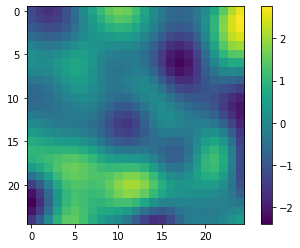

In [ ]:
heatmap2d(z)

## Applying VAE

In [ ]:
args = {"num_epochs": 100,
        "learning_rate": 1.0e-3,
        "batch_size": 100,
        "hidden_dim1": 35,
        "hidden_dim2": 30,
        "z_dim": 30,
         "x": x,
        "n": 25,
        "gp_kernel": exp_sq_kernel,
        "rng_key": random.PRNGKey(1),
        "num_warmup": 1000,
        "num_samples": 1000,
        "num_chains": 4,
        "thinning": 1
        }

In [ ]:
def vae_encoder(hidden_dim1, hidden_dim2, z_dim):
    return stax.serial(
        stax.Flatten,
        stax.Dense(hidden_dim1, W_init=stax.randn()),
        stax.Relu,
        stax.Dense(hidden_dim2, W_init=stax.randn()),
        stax.Relu,
        stax.FanOut(2),
        stax.parallel(
            stax.Dense(z_dim, W_init=stax.randn()),  # mean
            stax.serial(stax.Dense(z_dim, W_init=stax.randn()), stax.Exp),  # std -- i.e. diagonal covariance
        ),
    )


def vae_decoder(hidden_dim1, hidden_dim2, out_dim):
    return stax.serial(
        stax.Dense(hidden_dim1, W_init=stax.randn()),
        stax.Relu,
        stax.Dense(hidden_dim2, W_init=stax.randn()),
        stax.Relu,
        stax.Dense(out_dim, W_init=stax.randn())
    )

def vae_model(batch, hidden_dim1, hidden_dim2, z_dim):
    batch = jnp.reshape(batch, (batch.shape[0], -1))
    batch_dim, out_dim = jnp.shape(batch)
    decode = numpyro.module("decoder", vae_decoder(hidden_dim1, hidden_dim2, out_dim), input_shape=(z_dim,))
    z = numpyro.sample("z", dist.Normal(jnp.zeros((batch_dim, z_dim)), jnp.ones((batch_dim, z_dim))))
    gen_loc = decode(z)
    return numpyro.sample("obs", dist.Normal(gen_loc, .1), obs=batch)


def vae_guide(batch, hidden_dim1, hidden_dim2, z_dim):
    batch = jnp.reshape(batch, (batch.shape[0], -1))
    batch_dim, out_dim = jnp.shape(batch)
    encode = numpyro.module("encoder", vae_encoder(hidden_dim1, hidden_dim2, z_dim), input_shape = (batch_dim, out_dim))
    z_loc, z_std = encode(batch)
    z = numpyro.sample("z", dist.Normal(z_loc, z_std))
    return z


@jit
def epoch_train(rng_key, svi_state, num_train):
    def body_fn(i, val):
        rng_key_i = random.fold_in(rng_key, i)
        rng_key_i, rng_key_ls, rng_key_var, rng_key_noise = random.split(rng_key_i, 4)
        loss_sum, svi_state = val  # val -- svi_state
        batch = gp_predictive(rng_key_i, gp_kernel=args["gp_kernel"], x=args["x"], jitter=1e-4)
        svi_state, loss = svi.update(svi_state, batch['y'])
        loss_sum += loss / args['batch_size']
        return loss_sum, svi_state

    return lax.fori_loop(0, num_train, body_fn, (0.0, svi_state))


@jit
def eval_test(rng_key, svi_state, num_test):
    def body_fn(i, loss_sum):
        rng_key_i = random.fold_in(rng_key, i)
        rng_key_i, rng_key_ls, rng_key_var, rng_key_noise = random.split(rng_key_i, 4)
        batch = gp_predictive(rng_key_i, gp_kernel=args["gp_kernel"], x=args["x"], jitter=1e-4)
        loss = svi.evaluate(svi_state, batch['y']) / args['batch_size']
        loss_sum += loss
        return loss_sum

    loss = lax.fori_loop(0, num_test, body_fn, 0.0)
    loss = loss / num_test

    return loss

In [ ]:
adam = numpyro.optim.Adam(step_size=args["learning_rate"])
svi = SVI(vae_model, vae_guide, adam, Trace_ELBO(),
          hidden_dim1=args["hidden_dim1"],
          hidden_dim2=args["hidden_dim2"],
          z_dim=args["z_dim"])

rng_key, rng_key_samp, rng_key_init = random.split(args["rng_key"], 3)
init_batch = gp_predictive(rng_key_predict, x=args["x"], gp_kernel=args["gp_kernel"])['y']
svi_state = svi.init(rng_key_init, init_batch)

test_loss_list = []

for i in range(args['num_epochs']):

    rng_key, rng_key_train, rng_key_test, rng_key_infer = random.split(rng_key, 4)

    t_start = time.time()

    num_train = 1000
    _, svi_state = epoch_train(rng_key_train, svi_state, num_train)

    num_test = 1000
    test_loss = eval_test(rng_key_test, svi_state, num_test)
    test_loss_list += [test_loss]

    print(
        "Epoch {}: loss = {} ({:.2f} s.)".format(
            i, test_loss, time.time() - t_start
        )
    )

    if math.isnan(test_loss): break

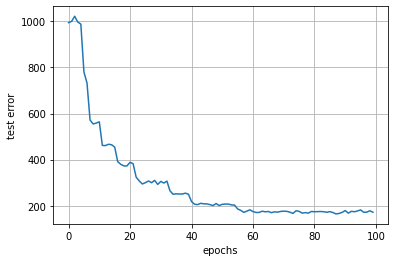

In [ ]:
plt.figure()
plt.grid()
plt.plot(np.arange(len(test_loss_list)), test_loss_list, label="test loss")
plt.xlabel("epochs")
plt.ylabel("test error")
plt.show()

In [ ]:
# To make the decoder available for future use, save after training:

decoder_params = svi.get_params(svi_state)["decoder$params"]
args["decoder_params"] = decoder_params

In [20]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [15]:
with open('/content/gdrive/My Drive/M4R/decoder_2d_n25', 'wb') as file:
    pickle.dump(decoder_params, file)

NameError: ignored

In [21]:
#Load
with open('/content/gdrive/My Drive/M4R/decoder_2d_n25', 'rb') as file:
    decoder_params = pickle.load(file)

args["decoder_params"] = decoder_params

## Obtain VAE samples

In [22]:
def vae_sample():
    z = numpyro.sample("z", dist.Normal(jnp.zeros(args['z_dim']), jnp.ones(args['z_dim'])))
    decoder_nn = vae_decoder(args["hidden_dim2"], args["hidden_dim1"], len(args["x"]))
    decoder_params = args["decoder_params"]
    f = numpyro.deterministic("f", decoder_nn[1](decoder_params, z))

In [ ]:
rng_key, rng_key_predict = random.split(random.PRNGKey(2))
vae_predictive = Predictive(vae_sample, num_samples=1000)
vae_draws = vae_predictive(rng_key_predict)['f']

In [ ]:
def mean_img(draws):
  sum = 0
  for img in draws:
    img = img.reshape((25, 25))
    sum = sum + img
  sum = sum/len(draws)
  return(sum)

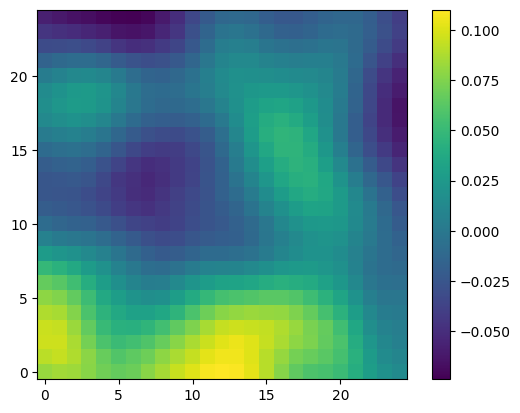

In [ ]:
heatmap2d(mean_img(vae_draws))

In [ ]:
sample_cov = jnp.cov(vae_draws, rowvar = False)

In [ ]:
length = 1
var = 0.1
jitter = 1e-5

In [ ]:
kernel_matrix = exp_sq_kernel(x, x, var, length, jitter)

In [ ]:
mse = (jnp.square(sample_cov - kernel_matrix)).mean(axis=None)

In [ ]:
mse

DeviceArray(0.00472506, dtype=float32)

In [ ]:
y1 = kernel_matrix[0][0:25]
y2 = sample_cov[0][0:25]
x = [i for i in range(25)]

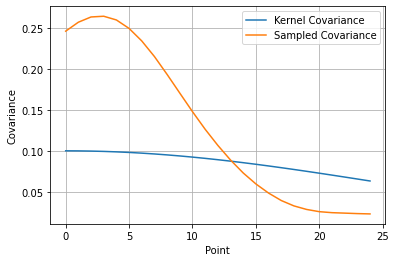

In [ ]:
plt.figure()
plt.grid()
plt.plot(x, y1, label="Kernel Covariance")
plt.plot(x, y2, label="Sampled Covariance")
plt.xlabel("Point")
plt.ylabel("Covariance")
plt.legend()
plt.show()

## Performing MCMC inference

In [23]:
covimod = pyreadr.read_r('pop.Rdata')['pop_df']

Since we are doing male-female interactions, what we want from this database is a matrix of the female population of ages between 6 and 30.

In [24]:
covimod = covimod.to_numpy()

In [25]:
pop_matrix = np.zeros((25, 25))

In [26]:
for i in range(25):
  for j in range(25):
    pop_matrix[i][j] = covimod[107+i][2]

In [27]:
logP = np.log(pop_matrix)

In [28]:
logP = jnp.asarray(logP)

In [29]:
args['logP'] = logP

In [30]:
old_intensity = pyreadr.read_r('data.rds')[None]

In [31]:
old_intensity

,alter_age,alter_gender,age,cntct_intensity,gender,cntct_rate,pop
0,6,Female,6,0.038971,Male,1.137047e-07,342735
1,6,Female,7,0.035561,Male,1.037555e-07,342735
2,6,Female,8,0.032151,Male,9.380636e-08,342735
3,6,Female,9,0.028741,Male,8.385720e-08,342735
4,6,Female,10,0.025331,Male,7.390804e-08,342735
...,...,...,...,...,...,...,...
7739,49,Male,45,0.256017,Male,3.727564e-07,686821
7740,49,Male,46,0.310341,Male,4.518507e-07,686821
7741,49,Male,47,0.365056,Male,5.315157e-07,686821
7742,49,Male,48,0.432895,Male,6.302885e-07,686821


In [32]:
def data_cut(dt):
  """
  Inputs:
  dt = pandas dataframe including all the gender interactions

  Outputs:
  dt_MF = pandas dataframe including only the male-female interactions
  """
  dt = dt.to_numpy()
  dt_MF = dt #Dataset only with contact intensities between males and females
  dt_MF_list = []
  for contact in dt_MF:
    if contact[1] == 'Female' and contact[4] == 'Male': #Male to female contacts
      if contact[0]<=30 and contact[2]<=30:
        contact = np.delete(contact, 1)
        contact = np.delete(contact, 3)
        dt_MF_list.append(contact)
  dt_MF = np.array(dt_MF_list)
  dt_MF = pd.DataFrame(dt_MF, columns = ['alter_age', 'age', 'cntct_intensity', 'cntct_rate', 'pop'], dtype = float)

  return dt_MF

In [33]:
dt = data_cut(old_intensity)

In [34]:
table = dt.pivot(index = 'alter_age', columns = 'age', values = 'cntct_intensity')

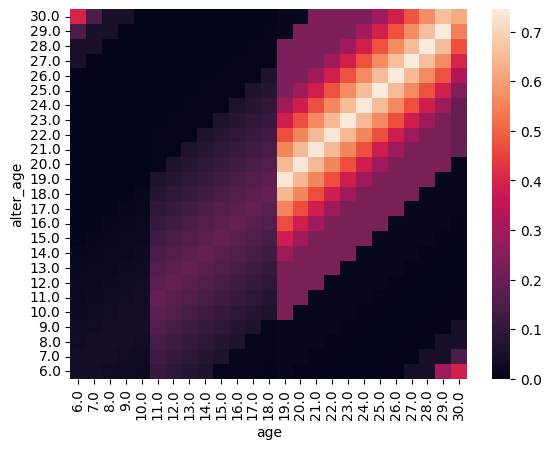

In [35]:
ax = sns.heatmap(table)
ax.invert_yaxis()
plt.show()

In [36]:
m = np.asarray(table)

In [39]:
old_participants = pyreadr.read_r('dt.rds')['dt']

In [40]:
def participants_matrix(dt):
  """
  Inputs:
  dt = pandas dataframe including all the gender interactions

  Outputs:
  dt_MF = pandas dataframe including number of male participants by age
  """
  dt = dt.to_numpy()
  dt_MF = dt #Dataset only with contact intensities between males and females
  dt_MF_list = []
  for contact in dt_MF:
    if contact[1] == 'Male' and contact[3] == 'Female': #Male to female contacts
      if contact[0]<=30 and contact[2]<=30:
        contact = np.delete(contact, 1)
        contact = np.delete(contact, 2)
        contact = np.delete(contact, 2)
        contact = np.delete(contact, 2)
        contact = np.delete(contact, 2)
        contact = np.delete(contact, 2)
        contact = np.delete(contact, 1)
        dt_MF_list.append(contact)
  dt_MF = np.array(dt_MF_list)
  dt_MF = pd.DataFrame(dt_MF, columns = ['age', 'part'], dtype = float)
  dt_MF = dt_MF.drop_duplicates()

  return dt_MF

In [41]:
part = np.asarray(participants_matrix(old_participants))

In [42]:
part_matrix = np.zeros((25, 25))

In [43]:
for i in range(25):
  for j in range(25):
    part_matrix[i][j] = part[j][1]

In [44]:
logN = jnp.log(jnp.asarray(part_matrix))

In [45]:
args['logN'] = logN

In [46]:
y = np.floor(np.multiply(m, part_matrix))

## Running MCMC

In [47]:
def contact_model_VAE(args, y = None):

  P = args['logP']
  N = args['logN']
  n = args['n']

  decoder_params = args["decoder_params"]
  z_dim, hidden_dim = decoder_params[0][0].shape
  z = numpyro.sample("z", dist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))
  decoder_nn = vae_decoder(args["hidden_dim2"], args["hidden_dim1"], n)
  f = numpyro.deterministic("f", decoder_nn[1](decoder_params, z))
  f = jnp.reshape(f, (25, 25))

  #fixed effects
  b0 = numpyro.sample('b0', dist.Normal(0, 10))
  v = numpyro.sample('v', dist.Exponential(1))
  tau = numpyro.sample('tau', dist.Normal(0, 1))
  rho = numpyro.sample('rho', dist.Normal(0, 1))

  lp = b0 + tau + f + P
  lu = lp + N + rho
  u = jnp.exp(lu)
  a = u/v

  if y is None:
    numpyro.sample("y_pred", dist.GammaPoisson(a, v/(1+v)))
  else:
    numpyro.sample("y", dist.GammaPoisson(a, v/(1+v)), obs=y)

In [49]:
rng_key, rng_key_predict = random.split(random.PRNGKey(6))

# inference
start = time.time()
kernel = NUTS(contact_model_VAE)
mcmc_vae = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains = 1, thinning = 2)
mcmc_vae.run(rng_key, args, y = y),
t_elapsed = time.time() - start

prev_samples = mcmc_vae.get_samples()
#mcmc.print_summary()

sample: 100%|██████████| 2000/2000 [05:04<00:00,  6.56it/s, 255 steps of size 1.94e-02. acc. prob=0.95]


In [50]:
print("\nMCMC elapsed time:", round(t_elapsed), "s")
ss = numpyro.diagnostics.summary(mcmc_vae.get_samples(group_by_chain=True))
r = np.mean(ss['f']['n_eff'])
print("Average ESS for all VAE-CAR effects : " + str(round(r)))


MCMC elapsed time: 306 s
Average ESS for all VAE-CAR effects : 406


In [51]:
mcmc_vae.print_summary(exclude_deterministic = False)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        b0    -13.81      1.45    -13.74    -16.17    -11.46    534.10      1.00
      f[0]     -0.62      0.23     -0.63     -0.99     -0.24    412.71      1.00
      f[1]     -0.62      0.24     -0.62     -1.07     -0.28    410.07      1.01
      f[2]     -0.59      0.25     -0.60     -1.05     -0.24    407.01      1.01
      f[3]     -0.54      0.26     -0.55     -1.00     -0.17    403.38      1.01
      f[4]     -0.47      0.26     -0.47     -0.91     -0.08    399.45      1.01
      f[5]     -0.36      0.26     -0.36     -0.80      0.04    385.96      1.01
      f[6]     -0.23      0.26     -0.23     -0.63      0.20    372.20      1.00
      f[7]     -0.09      0.26     -0.09     -0.49      0.34    361.73      1.00
      f[8]      0.02      0.26      0.02     -0.36      0.48    356.29      1.00
      f[9]      0.09      0.27      0.10     -0.33      0.52    356.87      1.00
     f[10]      0.11      0

In [61]:
y_list = []
for i in range(len(prev_samples['f'])):
  b0 = prev_samples['b0'][i]
  rho = prev_samples['rho'][i]
  tau = prev_samples['tau'][i]
  f = prev_samples['f'][i]
  v = prev_samples['v'][i]
  f = f.reshape(args['n'], args['n'])
  lm = f + b0 + logP + tau
  m_pred = jnp.exp(lm)
  lu = lm + rho + logN
  u = jnp.exp(lu)
  a = u/v
  rng_key, rng_key_predict = random.split(random.PRNGKey(2*i))
  y_pred = numpyro.sample('y', dist.GammaPoisson(a, v/(1+v)), rng_key = rng_key)
  y_list.append(y_pred)
y_avg = sum(y_list)/len(y_list)

In [62]:
np.mean(np.abs(y_avg-y))

0.5732928

In [63]:
np.mean(np.abs(y_avg/part_matrix - y/part_matrix))

0.051262733

In [ ]:
prev_samples_vae_az = az.from_numpyro(mcmc_vae)

array([[<Axes: title={'center': 'b0'}>, <Axes: title={'center': 'b0'}>],
       [<Axes: title={'center': 'rho'}>, <Axes: title={'center': 'rho'}>],
       [<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>],
       [<Axes: title={'center': 'v'}>, <Axes: title={'center': 'v'}>]],
      dtype=object)

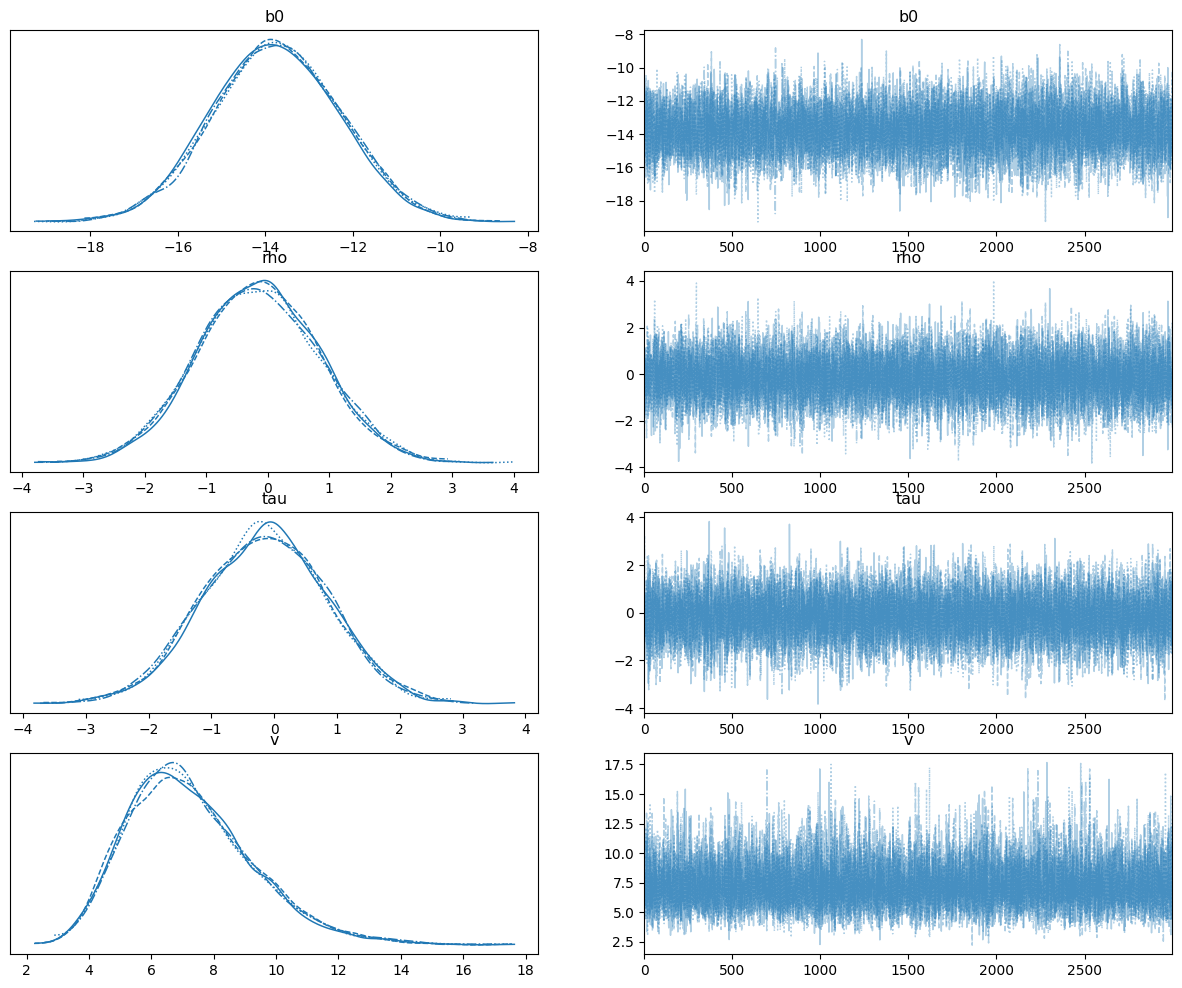

In [ ]:
az.plot_trace(prev_samples_vae_az, var_names = ("b0", "rho", "tau", "v"), figsize = (15, 12))

Text(0.5, 1.0, 'Simulated intensities')

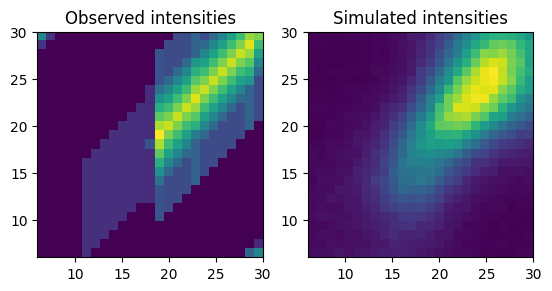

In [64]:
m_old = y/part_matrix
m_new = y_avg/part_matrix

plt.subplot(1, 2, 1)
plt.imshow(m_old, extent = (6, 30, 30, 6))
plt.gca().invert_yaxis()
plt.title('Observed intensities')

plt.subplot(1, 2, 2)
plt.imshow(m_new, extent = (6, 30, 30, 6))
plt.gca().invert_yaxis()
plt.title('Simulated intensities')

In [65]:
heatmap2d(m_new)

NameError: ignored

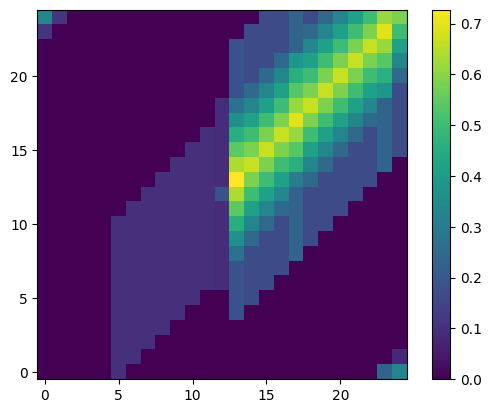

In [ ]:
heatmap2d(m_old)